<a href="https://colab.research.google.com/github/BVika/Machine_learning_methods/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_6_(%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи для домашки ⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

**По желанию**

1. Спарсить данные по статьям (например lenta.ru или naked-science.ru)
2. Преобразовать текста статьи (по принципу описанному в последнем пункте)
3. Оценить метрики качества, провести аналитику кластеров (можно не максимально подробно, если получилось слишком много кластеров)

## Предобработка (все по классике)

Открываем датасет, преобразуем данные, идем дальше

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/heart.csv')
df['risk_group']= np.where(df['IHD_DX']<=5, 1, 0)
df.risk_group = df.risk_group.astype('category')
df = df.drop('IHD_DX', axis=1)


df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AGE_50      200 non-null    int64   
 1   MD_50       200 non-null    int64   
 2   SBP_50      200 non-null    int64   
 3   DBP_50      200 non-null    int64   
 4   HT_50       200 non-null    int64   
 5   WT_50       200 non-null    int64   
 6   CHOL_50     200 non-null    int64   
 7   SES         200 non-null    int64   
 8   CL_STATUS   200 non-null    int64   
 9   MD_62       200 non-null    int64   
 10  SBP_62      200 non-null    int64   
 11  DBP_62      200 non-null    int64   
 12  CHOL_62     200 non-null    int64   
 13  WT_62       200 non-null    int64   
 14  DEATH       200 non-null    int64   
 15  risk_group  200 non-null    category
dtypes: category(1), int64(15)
memory usage: 23.9 KB


### Преобразование категориальных фич

In [147]:
df.risk_group = df.risk_group.astype('category')
# Создаем копию данных
category_columns: list[str] = df.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

 # Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)
df = df.drop('MD_50', axis=1)
df = df.drop('SES', axis=1)
df = df.drop('CL_STATUS', axis=1)
df = df.drop('MD_62', axis=1)
df.risk_group_1 = df.risk_group_1.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   AGE_50        200 non-null    int64
 1   SBP_50        200 non-null    int64
 2   DBP_50        200 non-null    int64
 3   HT_50         200 non-null    int64
 4   WT_50         200 non-null    int64
 5   CHOL_50       200 non-null    int64
 6   SBP_62        200 non-null    int64
 7   DBP_62        200 non-null    int64
 8   CHOL_62       200 non-null    int64
 9   WT_62         200 non-null    int64
 10  DEATH         200 non-null    int64
 11  risk_group_1  200 non-null    int64
dtypes: int64(12)
memory usage: 18.9 KB


In [ ]:
df

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2,1
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9,1
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2,1
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3,1
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0,0


### Преобразование непрерывных фич

In [148]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [149]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AGE_50        200 non-null    float64
 1   SBP_50        200 non-null    float64
 2   DBP_50        200 non-null    float64
 3   HT_50         200 non-null    float64
 4   WT_50         200 non-null    float64
 5   CHOL_50       200 non-null    float64
 6   SBP_62        200 non-null    float64
 7   DBP_62        200 non-null    float64
 8   CHOL_62       200 non-null    float64
 9   WT_62         200 non-null    float64
 10  DEATH         200 non-null    float64
 11  risk_group_1  200 non-null    float64
dtypes: float64(12)
memory usage: 18.9 KB


In [150]:
df

,AGE_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SBP_62,DBP_62,CHOL_62,WT_62,DEATH,risk_group_1
0,0.448980,0.180328,0.264706,0.214286,0.279412,0.412048,0.31250,0.318841,0.576419,0.275362,1.0,1.0
1,0.673469,0.344262,0.333333,0.571429,0.426471,0.380723,0.32500,0.173913,0.484716,0.413043,1.0,0.0
2,0.673469,0.262295,0.509804,0.642857,0.830882,0.534940,0.38750,0.492754,0.720524,0.833333,1.0,1.0
3,0.571429,0.262295,0.411765,0.785714,0.882353,0.286747,0.30000,0.173913,0.305677,0.862319,1.0,1.0
4,0.673469,0.245902,0.352941,0.357143,0.183824,0.296386,0.30000,0.000000,0.532751,0.217391,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.612245,0.221311,0.411765,0.357143,0.286765,0.433735,0.28125,0.130435,0.585153,0.318841,0.0,1.0
196,0.061224,0.180328,0.313725,0.571429,0.205882,0.000000,0.26250,0.289855,0.257642,0.326087,0.0,1.0
197,0.000000,0.344262,0.411765,0.357143,0.301471,0.216867,0.37500,0.420290,0.589520,0.362319,0.0,1.0
198,0.530612,0.426230,0.450980,0.357143,0.213235,0.024096,0.48750,0.463768,0.091703,0.355072,0.0,1.0


## О кластеризации и задачи обучения без учителя

#### Обучение с учителем

Представьте, что у вас есть список задач с правильными ответами. Например, вам дали примеры: «Это яблоко», «Это груша».

Задача — научиться отличать их, чтобы потом, когда вы увидите новый фрукт, вы смогли правильно его назвать. То есть у вас есть **учитель** — тот, кто заранее всё объяснил и дал правильные ответы.  

#### Обучение без учителя

А теперь представьте, что вам дали корзину фруктов, но никто не сказал, как они называются.

Задача — посмотреть на фрукты и найти, что у них общего, например: круглые положить в одну группу, длинные в другую. Тут вы работаете **без подсказок** и сами решаете, как группировать.  

#### Разница

- В задачах с учителем есть правильные ответы, и мы обучем алгоритм делать предсказания на основе примеров.  
- В задачах без учителя правильных ответов нет, ищем закономерности и пытаемся найти смысл группировки данные самостоятельно.

Пример:


1. **С учителем**: Мы ищем лучшее вино.  
2. **Без учителя**: Мы пытаемся объеденить вина, чтобы понять по какому принципу они объеденяются.  

## K-means

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [151]:
! pip install ipywidgets


In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):

    # преобразуем X в numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for step in range(max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            plot_kmeans_iteration(X, centroids, labels, step)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Берем датасет и визуализируем K-means
interactive_kmeans_visualization(df[:100])


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=10, min=2), IntSlider(value=10, desc…

### K-means через реализацию skelarn

In [154]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 3  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")


Статистика по кластерам:

Статистика для признака 'AGE_50':
             mean       std       min       max
Cluster                                        
0        0.663098  0.205931  0.102041  1.000000
1        0.463010  0.198792  0.000000  0.897959
2        0.521542  0.212566  0.081633  0.897959

Статистика для признака 'SBP_50':
             mean       std       min       max
Cluster                                        
0        0.329750  0.158032  0.098361  0.918033
1        0.280006  0.133669  0.000000  0.836066
2        0.321797  0.174762  0.131148  1.000000

Статистика для признака 'DBP_50':
             mean       std       min       max
Cluster                                        
0        0.447766  0.116122  0.264706  1.000000
1        0.436712  0.105369  0.000000  0.705882
2        0.472404  0.097017  0.313725  0.705882

Статистика для признака 'HT_50':
             mean       std       min       max
Cluster                                        
0        0.500000  0

#### **Анализ кластеров**



После применения алгоритма K-means с количеством кластеров \( k=3 \), мы получили три группы риска с заметными отличиями по некоторым признакам. Рассмотрим три наиболее значимых признака, по которым кластеры существенно различаются:

1. **risk_group_1 :**
   - **Кластер 0** и **Кластер 1** входят в группу риска ишемической болезни сердца (значение `mean = 1.0`).
   - **Кластер 2** не входят в группу риска (значение `mean = 0.0`).

2. **AGE_50 (Возраст):**

   - **Кластер 0** группа имеет самый высокий возраст  (`mean ≈ 0.663098`).
   - **Кластер 1** группа имеет возраст между 0 и 2 кластером (`mean ≈  0.463010`).
   - **Кластер 2** группа имеет самый младший возраст (`mean ≈ 0.521542`).
   - **Вывод:** Люди в группе риска в Кластере 0 это люди пожилового возраста, тогда как в Кластере 1 — это молодые люди.

3. **CHOL_62 (уровень холестерин):**

Статистика для признака 'CHOL_62':
             mean       std       min       max
Cluster                                        
0        0.455938  0.210248  0.000000  0.938865
1        0.522575  0.203790  0.048035  1.000000
2        0.524341  0.170542  0.170306  0.851528
   - **Кластер 1** у людей самым низким показатель холестерин  (`mean ≈0.45`), что заметно ниже, чем в Кластерах 1 и 2 (`mean ≈ 0.52` и `mean ≈ 0.53` соответственно).
   - **Вывод:** Люди который находятся в группе риска ишемической болезни сердца обладают низкими показателями холестерина, в отличие от людей, которые или не входят в группу риска, или находятся где-то между.

**Коэффициент силуэта для \( k=3 \): 0.4004**

Коэффициент силуэта — это метрика для оценки качества кластеризации, показывающая, насколько объекты внутри одного кластера похожи друг на друга и отличаются от объектов в других кластерах.

- **Диапазон значений:** от -1 до 1.
  - **Близкие к 1:** Хорошая кластеризация; объекты внутри кластеров схожи, кластеры хорошо разделены.
  - **Около 0:** Кластеры пересекаются; объекты находятся на границах кластеров.
  - **Отрицательные значения:** Плохая кластеризация; объекты могут быть отнесены к неправильным кластерам.

**Интерпретация полученного значения:**

- **0.4004** — это положительное значение, указывающее на удовлетворительное качество кластеризации.
- Кластеры достаточно хорошо разделены, но есть пересечение между ними.

Кластеризация позволила выделить группы людей с риском ишемической болезни,  (в группе риска или вне группы), по возрасту и уровню холестерина.

### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df[:120])


Output()

### DBSSCAN через sklearn

Количество кластеров: 3
Статистика по кластерам:

Статистика для признака 'AGE_50':
             mean       std       min       max  count
Cluster                                               
0        0.659864  0.206101  0.102041  1.000000     60
1        0.459276  0.195707  0.000000  0.897959    111
2        0.513605  0.223533  0.081633  0.897959     24

Статистика для признака 'SBP_50':
             mean       std       min       max  count
Cluster                                               
0        0.330874  0.159119  0.098361  0.918033     60
1        0.274996  0.123262  0.000000  0.672131    111
2        0.330943  0.181954  0.131148  1.000000     24

Статистика для признака 'DBP_50':
             mean       std       min       max  count
Cluster                                               
0        0.448366  0.117006  0.264706  1.000000     60
1        0.435170  0.104570  0.000000  0.705882    111
2        0.485703  0.092195  0.313725  0.705882     24

Статистика для призн

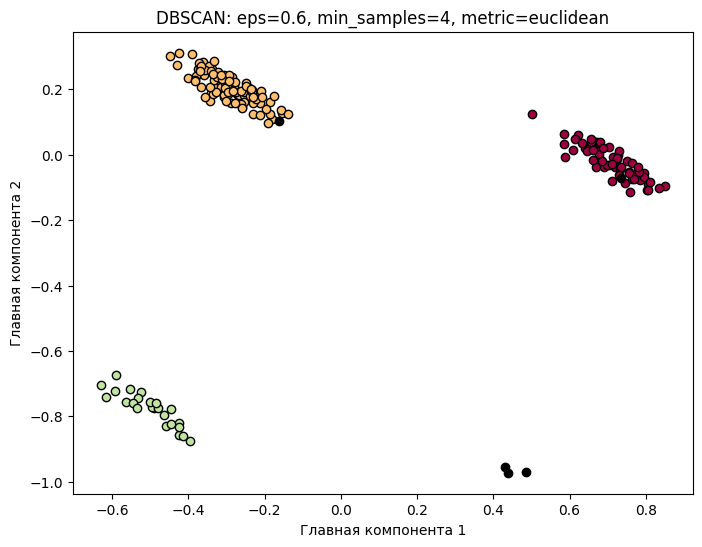

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.6
min_samples = 4
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

Статистика по кластерам
Для каждого признака приведены средние значения, стандартные отклонения, минимумы и максимумы, а также количество точек в каждом кластере.

Признак 'AGE_50'
Кластер 0: Среднее значение 0.66, стандартное отклонение 0.21, 60 точек.
Кластер 1: Среднее значение 0.46, стандартное отклонение 0.20, 111 точек.
Кластер 2: Среднее значение 0.51, стандартное отклонение 0.22, 24 точки.
Анализ: Кластер 0 имеет наибольшее среднее значение, что указывает на более старшую возрастную группу по сравнению с другими кластерами. Кластер 1 также содержит значительное количество людей старшего возраста, но в меньшей степени.

Признак 'SBP_50' (Систолическое артериальное давление)
Кластер 0: Среднее 0.33, стандартное отклонение 0.16.
Кластер 1: Среднее 0.27, стандартное отклонение 0.12.
Кластер 2: Среднее 0.33, стандартное отклонение 0.18.
Анализ: Кластер 0 и кластер 2 имеют более высокие значения систолического артериального давления по сравнению с кластером 1, что может указывать на более высокие риски сердечно-сосудистых заболеваний в этих группах.

Признак 'CHOL_62'ластеры 1 и 2 демонстрируют более высокие средние значения холестерина (0.524490 и 0.515284 соответственно), что может указывать на повышенные риски сердечно-сосудистых заболеваний в этих группах. Кластер 0 имеет более низкое среднее значение (0.454148) и более высокую вариативность, что может свидетельствовать о разнообразии факторов, влияющих на уровень холестерина.

Признак 'DEATH'
Кластер 0: Все 60 точек имеют значение 1 (смерть).
Кластер 1: Все точки имеют значение 0 (нет смерти).
Кластер 2: Все точки имеют значение 0 (нет смерти).
Анализ: Четкое разделение между кластерами. Кластер 0 явно имеет более высокий риск, что указывает на наличие факторов, способствующих летальности.

Коэффициент силуэта равен 0.4063, что указывает на приемлемое качество кластеризации. Значение выше 0.3 говорит о том, что точки в кластерах имеют определенную степень разделимости, однако значение ниже 0.5 может указывать на необходимость улучшения кластеризации.

### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [157]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 103.1744
Индекс Дэвиса-Болдина для K-means: 1.0727
Коэффициент силуэта для K-means: 0.4004


In [158]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.6
min_samples = 4

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Индекс Калински-Харабаза для DBSCAN: 105.2991
Индекс Дэвиса-Болдина для DBSCAN: 1.0405
Коэффициент силуэта для DBSCAN: 0.4063


#### Визуальный пример

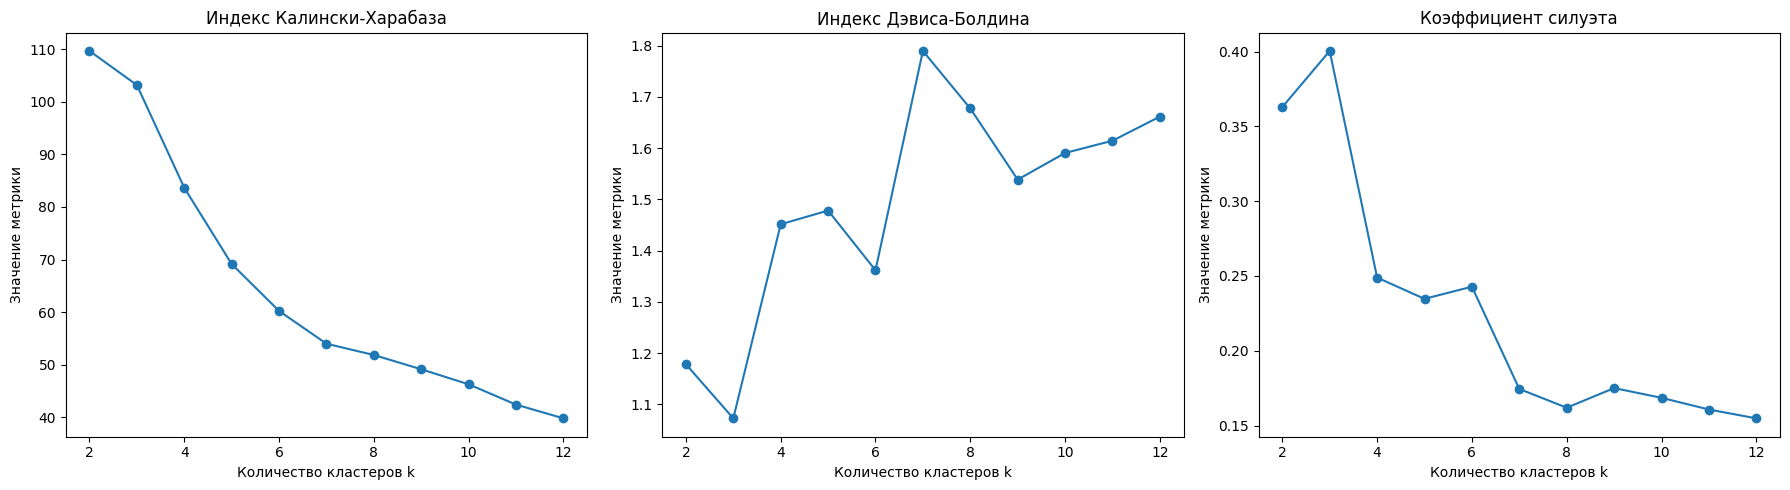

In [159]:
# Диапазон значений k
k_range = range(2, 13)

# Списки для хранения метрик
ch_scores = []
db_scores = []
silhouette_scores = []

for k in k_range:
    # Создаем и обучаем модель KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    # Вычисляем метрики
    ch_score = calinski_harabasz_score(df, labels)
    db_score = davies_bouldin_score(df, labels)
    silhouette_avg = silhouette_score(df, labels)

    # Сохраняем метрики
    ch_scores.append(ch_score)
    db_scores.append(db_score)
    silhouette_scores.append(silhouette_avg)

# Построение графиков
plt.figure(figsize=(18, 5))

# График Индекса Калински-Харабаза
plt.subplot(1, 3, 1)
plt.plot(k_range, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаза')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Индекса Дэвиса-Болдина
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Индекс Дэвиса-Болдина')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Коэффициента силуэта
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

plt.tight_layout()
plt.show()
